In [1]:
import os
os.environ['TRANSFORMERS_CACHE'] = str(os.getcwd())+"/cache"


In [2]:
!nvidia-smi

Sun Dec 12 19:44:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   32C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [3]:
#!/usr/bin/env python
# coding: utf-8

# !pip install transformers
# !pip install pytorch_lightning

# ## T5 fine-tuning with Pytorch Lightning and Wandb
# 
# 
#  [T5 model](https://arxiv.org/abs/1910.10683) with Huggingface's [Transformers](https://github.com/huggingface/transformers/) to solve different NLP tasks using text-2-text approach proposed in the T5 paper. 
#  
# Transfer Learning with T5 with wandb 
# Author Nafis Abrar 

import argparse
import glob
import os
import sys
import json
import time
import logging
import random
import re
import nltk
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
import pytorch_lightning.metrics.functional as FM
import torchmetrics
import sklearn
import seaborn as sns
import torch
import math
import matplotlib.pyplot as plt
import wandb
import tensorflow as tf
import tensorboard as tb
import multiprocessing

from tqdm.auto import tqdm
from sklearn import metrics
from itertools import chain
from string import punctuation
from argparse import ArgumentParser
from torch.utils.data import Dataset, DataLoader
from torchmetrics import CohenKappa
from sklearn import preprocessing
from sklearn.metrics import cohen_kappa_score
from torchmetrics.functional import cohen_kappa
from transformers import (
    AdamW,
    Adafactor,
    T5ForConditionalGeneration,
    T5Tokenizer,
    T5Config,
    get_linear_schedule_with_warmup
)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pytorch_lightning.loggers import WandbLogger 
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from torchmetrics.functional import cohen_kappa
from nltk.tokenize import sent_tokenize
# scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler


nltk.download('punkt')
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

dataSeed = 12321
train_path = "Insert Train Folder containgin train.csv"
val_path = "Insert Val Folder path containg val.csv"
test_path = "Insert Test Folder path containg test.csv"

def getData(path):
    data = pd.read_csv(os.path.join(train_path, "train.csv"))
    data[args.label] = data[args.label].astype(int)
    data["label"] = data[args.label]
    data = data.sample(frac=1,random_state=seed).reset_index(drop=True)
    return data


def getValidationData(path):
    validation = pd.read_csv(val_path+"/val.csv")
    validation[args.label] = validation[args.label].astype(int)
    validation["label"] = validation[args.label]
    validation = validation.sample(frac=1,random_state=seed).reset_index(drop=True)   
    return validation
    
    
def getTestData(path):
    test =  pd.read_csv(test_path+"/test.csv")
    test[args.label] = test[args.label].astype(int)
    test["label"] = test[args.label]
    test = test.sample(frac=1,random_state=seed).reset_index(drop=True)
    return test
        

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)



# ## Model
# 
# We'll be using the awesome [pytorch-lightning](https://github.com/PytorchLightning/pytorch-lightning) library for training. Most of the below code is adapted from here https://github.com/huggingface/transformers/blob/master/examples/lightning_base.py
# 
# The trainer is generic and can be used for any text-2-text task. You'll just need to change the dataset. Rest of the code will stay unchanged for all the tasks.
# 
# This is the most intresting and powrfull thing about the text-2-text format. You can fine-tune the model on variety of NLP tasks by just formulating the problem in text-2-text setting. No need to change hyperparameters, learning rate, optimizer or loss function. Just plug in your dataset and you are ready to go!

# In[7]:

class T5Custom(pl.LightningModule):
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("T5Custom")
        parser.add_argument("--model_name", type=str, default="google/t5-v1_1-large")
        parser.add_argument("--model_name_or_path", type=str, default="google/t5-v1_1-large")
        parser.add_argument("--optimizer", type=str, default="AdamW")
        parser.add_argument("--tokenizer_name_or_path", type=str, default="google/t5-v1_1-large")
        parser.add_argument("--n_gpu", type=int, default=-1)
        parser.add_argument("--learning_rate", type=float, default=1e-4)
        parser.add_argument("--weight_decay", type=float, default=0.0)
        parser.add_argument("--adam_epsilon", type=float, default=1e-8)
        parser.add_argument("--warmup_steps", type=int, default=0)
        parser.add_argument("--num_train_epochs", type=int, default=12)
        parser.add_argument("--train_batch_size", type=int, default=16)
        parser.add_argument("--eval_batch_size", type=int, default=128)
        parser.add_argument("--gradient_accumulation_steps", type=int, default=2)
        parser.add_argument("--fp_16", type=int, default=0)
        parser.add_argument("--opt_level", type=str, default="O1")
        parser.add_argument("--max_grad_norm", type=float, default=1.0)
        parser.add_argument("--max_seq_length", type=int, default=512)
        parser.add_argument("--data_dir", type=str, default="")
        return parent_parser
        
        
    def __init__(self, hparams,*args, **kwargs):
        super().__init__()
        if type(hparams) is dict: hparams = argparse.Namespace(**hparams)
        self.save_hyperparameters(hparams) 
        print(f" hparams:\n{self.hparams}\n")
        self.tokenizer = AutoTokenizer.from_pretrained("t5-large")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("t5-large")
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.train_qwk = torchmetrics.CohenKappa(num_classes=5)
        self.val_qwk = torchmetrics.CohenKappa(num_classes=5)


    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    
    def _step(self, batch,return_text=False):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100
        pad_token_id = self.tokenizer.pad_token_id
        source_ids, source_mask, y = batch["source_ids"], batch["source_mask"], batch["target_ids"]
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone()
        # Change pad_token_id to -100
        lm_labels[y[:, 1:] == pad_token_id] = -100
        # Run forward pass and calculate loss
        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )    # Only get loss from the output since that's all we need to apply our optimizer

        loss = outputs[0]
        if return_text:
            target_text = [self.tokenizer.decode(ids) for ids in y_ids]
            return loss, target_text
        else:
            return loss

        
    def training_step(self, batch, batch_idx):
        """
        training_step, which takes a batch 
        and computes the loss; backprop goes through it
        """
        loss = self._step(batch)
        losses = loss.clone().detach()
        # self.log takes a name and value for a metric. Under the hood, this will get passed to wandb.log if you're using W&B.
        return {"loss": loss,"losses":losses}

        
    def training_epoch_end(self, outputs):
        if outputs:
            avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
            self.log('training-epoch-loss',avg_train_loss,on_step=False,on_epoch=True)
        return None

    
    def validation_step(self, batch, batch_idx):
        """
        methods that trigger on each batch for a dataset: validation_step and test_step
        """
        loss, target_text = self._step(batch, return_text=True)
        preds = self.test_step(batch, batch_idx)
        preds_text = preds["preds"]
        targets = [(int(x)) if x.isnumeric() else 0  for x in target_text ]
        outputs = [int(x)  if x.isnumeric() else 0 for x in preds_text ]
        return {"val_loss": loss,"labels":targets,"pred":outputs}

    # Gathered data from all processes (per single step)
    # Allows for accumulation so the whole data at the end of epoch
    # takes less memory
    def validation_step_end(self, batch_parts):
        predictions = batch_parts["pred"]
        labels = batch_parts["labels"]
        predictions = [int(t.item()) for tensor in predictions for t in tensor]
        outputs = [int(t.item()) for tensor in labels for t in tensor]
        kappa = sklearn.metrics.cohen_kappa_score(outputs, predictions, weights="quadratic")  
        if math.isnan(kappa):
            print ("kappa nan step")
        #Loss from individual GPUs
        #https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html
        losses = batch_parts["val_loss"]
        total_loss = (losses[0]+losses[1]+losses[2]+losses[3])/4
    #         self.log('valid/acc_epoch', self.val_acc(targetsToTens,outputsToTensor),on_epoch=True,sync_dist=True)
        self.log('val-epoch-loss', total_loss, on_epoch=True,sync_dist=True)
        self.log('val_qwk', kappa, on_epoch=True,on_step=False,sync_dist=True)
        self.log('val_qwk_step', kappa, on_step=True,sync_dist=True)

        print ("Step end qwk :",kappa,"val-loss : ",total_loss)
        cm = metrics.confusion_matrix(predictions, outputs)
#         print (cm)


    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay if args.optimizer=="AdamW" else 0.0,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        if args.optimizer=="AdamW":
            optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon, correct_bias=False,)
#         optimizer = AdaFactor(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon,correct_bias=False)
        else:
            optimizer = Adafactor(optimizer_grouped_parameters, scale_parameter=False, relative_step=False, warmup_init=False, lr=1e-3)
#         optimizer = Adafactor(optimizer_grouped_parameters, scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
        self.opt = optimizer
        return [optimizer]

    
    def optimizer_step(self,
                     epoch,
                     batch_idx,
                     optimizer,
                     optimizer_idx,
                     optimizer_closure=None,
                     on_tpu=None,
                     using_native_amp=None,
                     using_lbfgs=None):
        optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()


    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}
        return tqdm_dict

    
    def train_dataloader(self):
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=False, num_workers=self.hparams.num_workers)
        if self.hparams.gradient_accumulation_steps>1:
            print (self.hparams.gradient_accumulation_steps)
            t_total = (
                (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
                // self.hparams.gradient_accumulation_steps
                * float(self.hparams.num_train_epochs)
            )
            scheduler = get_linear_schedule_with_warmup(
                self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
            )
        else:
            tb_size = self.hparams.train_batch_size * max(1, self.hparams.n_gpu)
            ab_size = self.hparams.gradient_accumulation_steps * float(self.hparams.num_train_epochs)
            self.total_steps = (len(dataloader.dataset) // tb_size) // ab_size
            scheduler = get_linear_schedule_with_warmup(
                self.opt,
                num_warmup_steps=self.hparams.warmup_steps,
                num_training_steps=self.total_steps,
            )
        self.lr_scheduler = scheduler
        return dataloader
    # Step during testing

    def test_step(self, batch, batch_idx):
        """
        Runs forward pass on test set and returns calculated loss, predictions, and targets
        Note: this assumes that your test set has targets (doesn't have for kaggle).
        """
        outputs,targets = [],[]
        outs = self.model.generate(input_ids=batch['source_ids'], 
                                  attention_mask=batch['source_mask'], 
                                  max_length=2)

        dec = [tokenizer.decode(ids) for ids in outs]
        target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
        outputs.extend(dec)
        targets.extend(target)
        preds = [x.split(" ")[-1] for x in outputs]
        targets = [x.split("<")[0] for x in targets]
        return {"preds": preds}
    
    
    def val_dataloader(self):
        val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
        return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4,drop_last=True)
    

def get_dataset(tokenizer, type_path, args):
    return Dataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length,args=args)


############################Dataset####################################################################
class Dataset(Dataset):
    def __init__(self, tokenizer, data_dir, type_path, args, max_len=512):
        self.path = args.train_path if type_path=="train" else args.val_path if type_path=="val" else args.test_path
        self.data_column = args.input
        self.class_column = args.label
        self.data = getValidationData(self.path) if type_path=="val" else getData(self.path) if type_path=="train" else getTestData(self.path)
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()
        src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze
        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

    def _build(self):
        for idx in range(len(self.data)):
            
            input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
            input_,target = str(input_),str(target)
            input_ = input_ + ' </s>'
            target = target + " </s>"

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
              [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
              [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)


# In[9]:


# logger = logging.getLogger(__name__)
wandb_logger = WandbLogger(log_model=True)  # newline 2
logger=wandb_logger


class wandbCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    wandb.log({key:metrics[key]})
        


# 
# Let's define the hyperparameters and other arguments. You can overide this `dict` for specific task as needed. While in most of cases you'll only need to change the `data_dir`and `output_dir`.
# 
# Here the batch size is 8 and gradient_accumulation_steps are 16 so the effective batch size is 128

"""
################## Argparser Best Practices ########################

Argparser Best Practices
It is best practice to layer your arguments in three sections.

1.Trainer args (gpus, num_nodes, etc…)

2.Model specific arguments (layer_dim, num_layers, learning_rate, etc…)

3.Program arguments (data_path, cluster_email, etc…)

#####################################################################
"""
parser = ArgumentParser(description='Initiating script')
# add PROGRAM level args
parser.add_argument("--train_path", type=str, default=train_path)
parser.add_argument("--val_path", type=str, default=val_path)
parser.add_argument("--test_path", type=str, default=test_path)
parser.add_argument("--input", type=str, default="insert input column name")
parser.add_argument("--label", type=str, default="insert label name")
parser.add_argument("--path", type=str, default="/")
parser.add_argument("--output_dir", type=str, default="/")
parser.add_argument("--augment", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=multiprocessing.cpu_count()-4)
parser.add_argument("--accelerators", type=str, default="dp")
parser.add_argument("--seed", type=int, default=42)

# add model specific args
parser = T5Custom.add_model_specific_args(parser)
# add all the available trainer options to argparse
# ie: now --gpus --num_nodes ... --fast_dev_run all work in the cli
parser = pl.Trainer.add_argparse_args(parser)
args = parser.parse_args(args=[])
set_seed(args.seed)

# add model specific args
model_name = args.model_name
target_col = args.label
seed = args.seed
augmentation = 0

####################WANDB#####################################################
wandb.login()
wandb.init(project=args.label,name=str(args.model_name+args.label))
wconfig = wandb.config
###############################################################################
os.chdir(args.path)
tokenizer = T5Tokenizer.from_pretrained(args.model_name)
# ### Train


# In[13]:
PATH = args.path

####################CallBack#####################################################

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=args.output_dir,
    filename="mta-{target_col}-{val_qwk_step}", monitor="val_qwk_step", mode="max", save_top_k=1,every_n_train_steps=10,
)
###############################################################################

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    accelerator=args.accelerators,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16==1 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    logger=WandbLogger(log_model=True),
    callbacks=[checkpoint_callback,wandbCallback()],

)

model = T5Custom(args)

# For Gradual Freezing

# for name,param in model.model.named_parameters():
#     if ('final_layer_norm' in name) or ("decoder.block.23" in name) or ("lm_head.weight") or ("decoder.final_layer_norm.weight") in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
#     print (name,param.requires_grad)

trainer = pl.Trainer(**train_params)
trainer.fit(model)




/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework

Namespace(accelerator=None, accelerators='dp', accumulate_grad_batches=1, adam_epsilon=1e-08, amp_backend='native', amp_level='O2', augment=1, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, benchmark=False, check_val_every_n_epoch=1, checkpoint_callback=True, data_dir='', default_root_dir=None, deterministic=False, devices=None, distributed_backend=None, eval_batch_size=128, fast_dev_run=False, flush_logs_every_n_steps=100, fp_16=0, gpus=None, gradient_accumulation_steps=2, gradient_clip_algorithm='norm', gradient_clip_val=0.0, input='essay', ipus=None, label='score_evidence', learning_rate=0.0001, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gpu_memory=None, logger=True, max_epochs=None, max_grad_norm=1.0, max_seq_length=512, max_steps=None, max_time=None, min_epochs=None, min_steps=None, model_name='google/t5-v1_1-large', model_name_or_path='google/t5-v1_1-large', move_metrics_to

E1212 19:45:38.149128 47994523938368 jupyter.py:137] Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sharar123 (use `wandb login --relogin` to force relogin)


/home/nafis/jupyter_py3/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /home/nafis/projects/def-kevinlb/nafis/t5/results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


 hparams:
"accelerator":                       None
"accelerators":                      dp
"accumulate_grad_batches":           1
"adam_epsilon":                      1e-08
"amp_backend":                       native
"amp_level":                         O2
"augment":                           1
"auto_lr_find":                      False
"auto_scale_batch_size":             False
"auto_select_gpus":                  False
"benchmark":                         False
"check_val_every_n_epoch":           1
"checkpoint_callback":               True
"data_dir":                          
"default_root_dir":                  None
"deterministic":                     False
"devices":                           None
"distributed_backend":               None
"eval_batch_size":                   128
"fast_dev_run":                      False
"flush_logs_every_n_steps":          100
"fp_16":                             0
"gpus":                              None
"gradient_accumulation_steps":       

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/nafis/jupyter_py3/lib/python3.6/site-packages/pytorch_lightning/trainer/configuration_validator.py:86: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding`LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch(rather, they are called on every optimization step).
  "When using `Trainer(accumulate_grad_batches != 1)` and overriding"
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.

  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | T5ForConditionalGeneration | 737 M 
1 | train_acc | Accuracy                   | 0     
2 | val_acc   | Accuracy                   | 0     
3 | train_qwk | CohenKappa                 | 0     
4 | val_qwk   | CohenKappa                 | 0     
----------------------------------------------

Validation 1017


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/nafis/jupyter_py3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Step end qwk : 0.0 val-loss :  tensor(19.6781, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(19.3552, device='cuda:0')
2


Step end qwk : 0.0 val-loss :  tensor(0.7944, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(0.7678, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(0.8275, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(0.8067, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(0.7877, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(0.7426, device='cuda:0')
Step end qwk : 0.0 val-loss :  tensor(0.7440, device='cuda:0')


Step end qwk : 0.03507046869878727 val-loss :  tensor(0.7691, device='cuda:0')
Step end qwk : -0.0024330900243310083 val-loss :  tensor(0.7396, device='cuda:0')
Step end qwk : 0.03928774781303379 val-loss :  tensor(0.8377, device='cuda:0')
Step end qwk : 0.10960799385088393 val-loss :  tensor(0.7125, device='cuda:0')
Step end qwk : 0.04044495496040146 val-loss :  tensor(0.7469, device='cuda:0')
Step end qwk : 0.06847171140151809 val-loss :  tensor(0.7069, device='cuda:0')
Step end qwk : 0.07942154512412036 val-loss :  tensor(0.7057, device='cuda:0')


Step end qwk : 0.03511208093632212 val-loss :  tensor(0.7660, device='cuda:0')
Step end qwk : -0.021485573971761873 val-loss :  tensor(0.7460, device='cuda:0')
Step end qwk : 0.11158387405595149 val-loss :  tensor(0.8231, device='cuda:0')
Step end qwk : 0.13620237544346758 val-loss :  tensor(0.6981, device='cuda:0')
Step end qwk : 0.14724838869608325 val-loss :  tensor(0.7193, device='cuda:0')
Step end qwk : 0.09752639042067124 val-loss :  tensor(0.7019, device='cuda:0')
Step end qwk : 0.0927962819519752 val-loss :  tensor(0.6953, device='cuda:0')


Step end qwk : 0.05040650406504066 val-loss :  tensor(0.7643, device='cuda:0')
Step end qwk : -0.024630541871921263 val-loss :  tensor(0.7568, device='cuda:0')
Step end qwk : 0.1459666393218485 val-loss :  tensor(0.8116, device='cuda:0')
Step end qwk : 0.11614555046939246 val-loss :  tensor(0.6936, device='cuda:0')
Step end qwk : 0.1751731213131572 val-loss :  tensor(0.7096, device='cuda:0')
Step end qwk : 0.08278622898318655 val-loss :  tensor(0.7163, device='cuda:0')
Step end qwk : 0.06112469437652812 val-loss :  tensor(0.6994, device='cuda:0')


Step end qwk : 0.16042146395924917 val-loss :  tensor(0.7573, device='cuda:0')
Step end qwk : -0.024039962535123305 val-loss :  tensor(0.7623, device='cuda:0')
Step end qwk : 0.1499118165784833 val-loss :  tensor(0.8259, device='cuda:0')
Step end qwk : 0.11159635030804027 val-loss :  tensor(0.6922, device='cuda:0')
Step end qwk : 0.22745660968289183 val-loss :  tensor(0.7222, device='cuda:0')
Step end qwk : 0.09341104095839403 val-loss :  tensor(0.7254, device='cuda:0')
Step end qwk : 0.054863040889241765 val-loss :  tensor(0.6989, device='cuda:0')


Step end qwk : 0.13149060781372757 val-loss :  tensor(0.7659, device='cuda:0')
Step end qwk : 0.017499204581609917 val-loss :  tensor(0.7829, device='cuda:0')
Step end qwk : 0.1252430515841244 val-loss :  tensor(0.8151, device='cuda:0')
Step end qwk : 0.2240042974445553 val-loss :  tensor(0.6945, device='cuda:0')
Step end qwk : 0.22521303936155823 val-loss :  tensor(0.7118, device='cuda:0')
Step end qwk : 0.0883932931792284 val-loss :  tensor(0.7288, device='cuda:0')
Step end qwk : 0.07482546201232032 val-loss :  tensor(0.6955, device='cuda:0')


Step end qwk : 0.2148391641230336 val-loss :  tensor(0.8034, device='cuda:0')
Step end qwk : 0.024125779343995624 val-loss :  tensor(0.8460, device='cuda:0')
Step end qwk : 0.25209210200544685 val-loss :  tensor(0.8632, device='cuda:0')
Step end qwk : 0.30494669227203497 val-loss :  tensor(0.6903, device='cuda:0')
Step end qwk : 0.27296220523312154 val-loss :  tensor(0.7518, device='cuda:0')
Step end qwk : 0.19859303552585295 val-loss :  tensor(0.7762, device='cuda:0')
Step end qwk : 0.21037504381352967 val-loss :  tensor(0.7382, device='cuda:0')


Step end qwk : 0.15974474317397214 val-loss :  tensor(0.8034, device='cuda:0')
Step end qwk : 0.05249547452805792 val-loss :  tensor(0.8135, device='cuda:0')
Step end qwk : 0.28135527022408824 val-loss :  tensor(0.8469, device='cuda:0')
Step end qwk : 0.2627381479840496 val-loss :  tensor(0.7004, device='cuda:0')
Step end qwk : 0.3018069973087274 val-loss :  tensor(0.7717, device='cuda:0')
Step end qwk : 0.1686560876281421 val-loss :  tensor(0.7884, device='cuda:0')
Step end qwk : 0.23370469970546803 val-loss :  tensor(0.7312, device='cuda:0')


Step end qwk : 0.22040223927016378 val-loss :  tensor(0.8436, device='cuda:0')
Step end qwk : 0.08028503562945366 val-loss :  tensor(0.8644, device='cuda:0')
Step end qwk : 0.2615833637358628 val-loss :  tensor(0.8940, device='cuda:0')
Step end qwk : 0.29941357162803683 val-loss :  tensor(0.7570, device='cuda:0')
Step end qwk : 0.32676300873206354 val-loss :  tensor(0.8150, device='cuda:0')
Step end qwk : 0.12677895286590934 val-loss :  tensor(0.8398, device='cuda:0')
Step end qwk : 0.23314065510597304 val-loss :  tensor(0.7698, device='cuda:0')


Step end qwk : 0.2603135534271497 val-loss :  tensor(0.8664, device='cuda:0')
Step end qwk : 0.04682520225545472 val-loss :  tensor(0.9330, device='cuda:0')
Step end qwk : 0.22880592058446791 val-loss :  tensor(0.9119, device='cuda:0')
Step end qwk : 0.3580926180651077 val-loss :  tensor(0.7599, device='cuda:0')
Step end qwk : 0.21935548639694813 val-loss :  tensor(0.8971, device='cuda:0')
Step end qwk : 0.08437583178067609 val-loss :  tensor(0.8666, device='cuda:0')
Step end qwk : 0.12974721456810834 val-loss :  tensor(0.8164, device='cuda:0')


Step end qwk : 0.2797265316855114 val-loss :  tensor(0.8868, device='cuda:0')
Step end qwk : 0.04995287464655984 val-loss :  tensor(0.9665, device='cuda:0')
Step end qwk : 0.22113836537550902 val-loss :  tensor(0.9431, device='cuda:0')
Step end qwk : 0.3699693091667149 val-loss :  tensor(0.7513, device='cuda:0')
Step end qwk : 0.21657250470809797 val-loss :  tensor(0.9168, device='cuda:0')
Step end qwk : 0.09453115086917907 val-loss :  tensor(0.8947, device='cuda:0')
Step end qwk : 0.1410416295504484 val-loss :  tensor(0.8312, device='cuda:0')


Step end qwk : 0.21345859733449857 val-loss :  tensor(0.9440, device='cuda:0')
Step end qwk : -0.008064516129032251 val-loss :  tensor(0.9823, device='cuda:0')
Step end qwk : 0.1871118374970815 val-loss :  tensor(0.9990, device='cuda:0')
Step end qwk : 0.3331689272503082 val-loss :  tensor(0.7511, device='cuda:0')
Step end qwk : 0.16828050147793294 val-loss :  tensor(0.9676, device='cuda:0')
Step end qwk : 0.09433962264150941 val-loss :  tensor(0.9110, device='cuda:0')
Step end qwk : 0.16094032549728754 val-loss :  tensor(0.8662, device='cuda:0')



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Test datasize 224


/home/nafis/jupyter_py3/lib/python3.6/site-packages/transformers/models/t5/tokenization_t5.py:191: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Step end qwk : 0.2072230786170447 val-loss :  tensor(0.8824, device='cuda:0')
Step end qwk : 0.026817804810616575 val-loss :  tensor(0.8802, device='cuda:0')
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val-epoch-loss': 0.8814563751220703,
 'val_qwk': 0.1299065202474594,
 'val_qwk_step': 0.1299065202474594,
 'val_qwk_step_epoch': 0.1299065202474594}
--------------------------------------------------------------------------------
 hparams:
"accelerator":                       None
"accelerators":                      dp
"accumulate_grad_batches":           1
"adam_epsilon":                      1e-08
"amp_backend":                       native
"amp_level":                         O2
"augment":                           1
"auto_lr_find":                      False
"auto_scale_batch_size":             False
"auto_select_gpus":                  False
"benchmark":                         False
"check_val_every_n_epoch":    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Step end qwk : 0.2072230786170447 val-loss :  tensor(0.8824, device='cuda:0')
Step end qwk : 0.026817804810616575 val-loss :  tensor(0.8802, device='cuda:0')
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val-epoch-loss': 0.8814563751220703,
 'val_qwk': 0.1299065202474594,
 'val_qwk_step': 0.1299065202474594,
 'val_qwk_step_epoch': 0.1299065202474594}
--------------------------------------------------------------------------------


Looping
Looping

              precision    recall  f1-score   support

           1       0.25      0.19      0.22        26
           2       0.00      0.00      0.00        27
           3       0.24      0.33      0.28        52
           4       0.45      0.57      0.50        97
           5       0.08      0.05      0.06        22

    accuracy                           0.35       224
   macro avg       0.20      0.23      0.21       224
weighted avg       0.29      0.35      0.31       224

0.12705363085438048


/home/nafis/jupyter_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'sns' is not defined

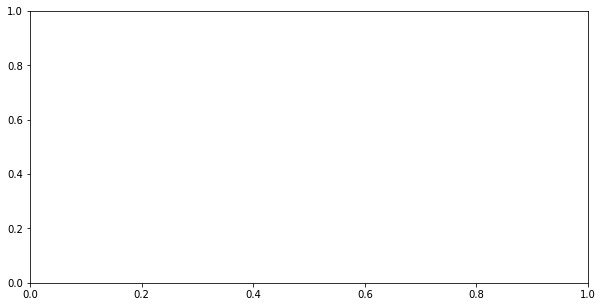

In [4]:
####################Validate#####################################################
dataset = Dataset(tokenizer, '', 'test',args=args)
vloader = DataLoader(dataset, batch_size=128, num_workers=args.num_workers)
trainer.validate(dataloaders=vloader)




checkpoint = torch.load(checkpoint_callback.best_model_path)
args = argparse.Namespace(**checkpoint)

model = T5Custom(checkpoint["hyper_parameters"])
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.validate(model)



model.model.eval()
outputs = []
targets = []
for batch in tqdm(vloader):
    outs = model.model.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'], 
                              max_length=2)
    dec = [tokenizer.decode(ids) for ids in outs]
    target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
    outputs.extend(dec)
    targets.extend(target)
    print ("Looping")
outputs = [x.split(" ")[-1] for x in outputs]
targets = [x.split("<")[0] for x in targets]
print(metrics.classification_report(targets, outputs))
y = [(int(x)) for x in targets]
pred = [int(x) for x in outputs]

# print (sklearn.metrics.cohen_kappa_score(o, t, weights="quadratic"))
# cm = metrics.confusion_matrix(t, o)
# df_cm = pd.DataFrame(cm, index = ["1","2","3","4","5"], columns = ["1","2","3","4","5"])
# plt.figure(figsize = (10,5))
# sn.heatmap(df_cm, annot=True, cmap='Purples', fmt='g')
CURPATH = os.getcwd()
outputdir = "./RunResults/"+str(dataSeed)
filename = str(seed)
filepath = str(seed)+".txt"
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

test_qwk = sklearn.metrics.cohen_kappa_score(pred, y, weights="quadratic")
print (test_qwk)
cm = confusion_matrix(y,pred)
cm


df_cm = pd.DataFrame(cm, index = ["1","2","3","4","5"], columns = ["1","2","3","4","5"])
plt.figure(figsize = (10,5))
ax= plt.subplot()
sns.heatmap(df_cm, annot=True, cmap='Purples', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.savefig("./"+outputdir+"/"+filename+'_test_confusion_matrix_'+str(dataSeed)+'.jpg')


In [ ]:
with open(outputdir+"/"+str(test_qwk)+"_"+str(dataSeed)+"_"+filepath, 'w') as f:
    f.write("Validation QWK  : "+ str(val_qwk))
    f.write("Test QWK : "+ str(test_qwk))
    f.close()